# Business Environments of Berlin Neighborhoods – Cluster Analysis #

## 1. Introduction to the Project ##

2020 is a challenging year for starting a business, as the Covid-19 pandemic has reduced demand for most free-time activities as public restrictions limit allowed activities.  These new factors, combined with the preexisting challenges associated with opening a business, make it necessary that a business’s product or service is appropriately matched to the demographics and consumer preferences in its operational location.  This project aims to support entrepreneurs by giving them a clearer understanding of the business environments for each district and neighborhood through clustering at the district and neighborhood levels according to the most popular business categories in each district.  Cluster analysis of available data (described below) will allow entrepreneurs to select the appropriate location for their business to ensure it is suited to local tastes to increase chances of success.

**Question:** Which types of businesses/venues appear to be most common at the district and neighborhood levels throughout the city of Berlin?

## 2. Introduction to the Data ##

### 2.1 Overview of Datasets ###
* **Foursquare API venue data:** This API grants developers free access to a massive set of crowdsourced business listing and locational data.  Foursquare powers location data for popular Apps such as Uber, Snapchat, Twitter, AppleMaps, and many more.  Through gathering data on listed businesses in each Berlin district and neighborhood through calls to the Foursquare API, business data can be analyzed to provide insights into the district- and neighborhood-level business environments throughout the city of Berlin. 

* **[Berlin Open Data Portal](https://daten.berlin.de/datensaetze) Datasets:** The Berlin government publishes and updates open source datasets covering a wide range of aspects to aid public and private analysis on trends and developments in the city.
    * **[Registered Residents in Berlin Districts on 31/12/2019](https://www.statistik-berlin-brandenburg.de/opendata/EWR_Ortsteile_2019-12-31.csv) Dataset –** the most recent update to this dataset which contains the number of residents broken down by age groups and at the district and neighborhood levels.

* **The Open Data Information Agency of the Technology Foundation Berlin's [Foundational Geodatasets of Berlin](https://daten.odis-berlin.de) Portal:** seeks to enable Berlin's up-and-coming tech sector through providing a number of open source foundational Geodatasets to enable more consistent geospatial analysis and visualization.
    * **[Berlin Districts Geospatial Dataset](https://daten.odis-berlin.de/de/dataset/bezirksgrenzen/):** provides geospatial boundaries of Berlin's 12 administrative districts.
    * **[Berlin Neighborhoods Geospatial Dataset](https://daten.odis-berlin.de/de/dataset/ortsteile/):** provides geospatial boundaries of Berlin's 96 neighborhoods.

### 2.2 Using Datasets to Solve The Problem ###

1. The geospatial datasets can be used in visualizing districts and neighborhoods over maps of Berlin, as well as in calculating representative central points of each district or neighborhood in order to make calls to the Foursquare API to retrieve venue data for each district or neighborhood.  Important data to be used is number and categories of venues.
1. The dataset on registered residents in each district can then be used to gain some insight into the demographics of each district or neighborhood according to the characteristics of population age. 
1. After processing venue and demographic data, both regression and cluster analysis can be used to understand trends in the business environments of each district and neighborhood, and ultimately to cluster districts and neighborhoods according to the most popular venue categories.  The data analysis and visualizations produced could then be used by entrepreneurs in exploring which districts or neighborhoods have the most appropriate demographics and consumer preferences for their planned business.

## 3. Methodology ##

Shown below are the Python libraries that will be used in this analysis, they are discussed in more detail as they are applied throughout this notebook.

In [1]:
import numpy as np
import pandas as pd
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import urllib
import io
import json
import lxml.html as lh
import bs4 as bs
import pyproj
from geopy.geocoders import Nominatim
from shapely.geometry import shape, Point
import shapely.ops as ops
import geopandas as gpd
import contextily as ctx

### 3.1 Data Wrangling ###

Before analysis can be done, the datasets must be extracted and read into dataframes, cleaned for duplicates and errors, and merged into unified datasets when necessary.

#### 3.1.1: Geospatial Datasets ####

To make sure our calls to the Foursquare API return venue data that is representative of the geographical areas, central representative points are needed for each district and neighborhood.  Luckily, the Python libary PyProj simplifies the process of projecting & transforming geospatial data.  The Shapely library allows us to calculate polygon area and their representative points, which were chosen over centroids since representative points are central points guaranteed to be within the boundaries of each polygon to account for irregular shapes.  Area is calculated through transforming coordinates from the latitude/longitude coordinate reference system (CRS) to an Albers Equal Area projection, which is useful in minimizing area distortions that come with navigation-oriented CRSs such as lat/long.  Area results are then converted from m<sup>2</sup> to km<sup>2</sup> for improved readability.  Representative points are in the standard lat/long CRS.

**The 12 Districts of Berlin**

In [3]:
urldistr = 'https://tsb-opendata.s3.eu-central-1.amazonaws.com/bezirksgrenzen/bezirksgrenzen.geojson'
distr_json = requests.get(urldistr).json()

In [4]:
area = []
lats = []
lons = []
name = []

for feature in distr_json['features']:
        name.append(feature['properties']['Gemeinde_name'])
        polygon = shape(feature['geometry'])
        p=polygon.representative_point()
        lons.append(p.x)
        lats.append(p.y)
        
        geom_aea = ops.transform(
            pyproj.Proj(
            proj='aea',
            lat_1=polygon.bounds[1],
            lat_2=polygon.bounds[3]),
        polygon)
        a = geom_aea.area/1000**2
        area.append(a)             

districts= pd.DataFrame(data={'District':name, 'Latitude':lats, 'Longitude':lons, 'Area':area})
districts.sort_values(['District'], ascending=True, axis=0, inplace=True)
districts.reset_index(drop=True, inplace=True)
districts

,District,Latitude,Longitude,Area
0,Charlottenburg-Wilmersdorf,52.507963,13.272751,64.692823
1,Friedrichshain-Kreuzberg,52.506897,13.450698,20.399734
2,Lichtenberg,52.532284,13.490921,52.119980
3,Marzahn-Hellersdorf,52.522474,13.585397,61.817755
4,Mitte,52.533230,13.359798,39.398803
5,Neukölln,52.445896,13.443075,44.931675
6,Pankow,52.597658,13.436379,103.216361
7,Reinickendorf,52.604845,13.288142,89.322845
8,Spandau,52.519206,13.181870,91.875065
9,Steglitz-Zehlendorf,52.429450,13.242071,102.560082


In [5]:
districts['Area'].describe()

count     12.000000
mean      74.259965
std       39.400975
min       20.399734
25%       50.322904
50%       63.255289
75%       94.546319
max      167.734542
Name: Area, dtype: float64

***Note on district areas and geospatial queries:*** The the average area of Berlin's districts is 74.3km<sup>2</sup>, although the overall range of district areas is quite large at 147.3 km<sup>2</sup>.  To account for this, the radius used in our subsequent inquiry will be set at *half of the mean (74.3) plus one standard deviation (39.4)*, or **56.85 km.** To account for this resulting in geospatial queries larger than some of the inner districts themselves, duplicates from this query will be removed before analysis.

**Visualizing Districts** For visualization this project uses two libraries, GeoPandas and Folium.  Folium is useful for geospatial visualizations on OpenStreetMap, which gives us interactive visualizations.  GeoPandas' visualization tools are well-suited for static images, such as the one generated below where the same GeoJSON file to generate a GeoDataSeries, rather than a Pandas dataframe, that is used to visualize 

<AxesSubplot:>

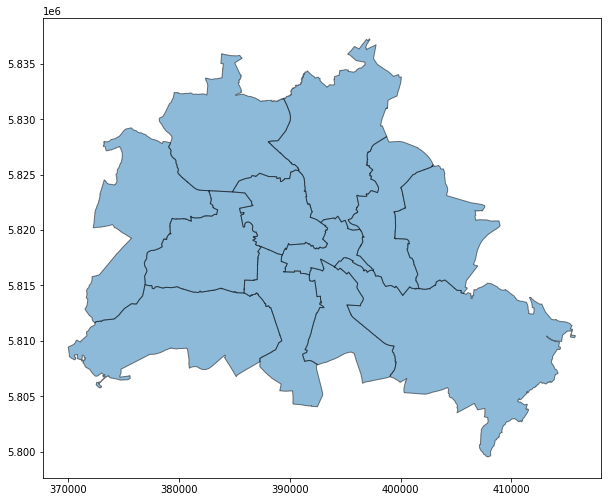

In [6]:
distr_gdf = gpd.read_file(urldistr)
distr_gdf = distr_gdf[['Gemeinde_name','geometry']]
distr_utm = distr_gdf.to_crs(epsg=32633) #converts to UTM Zone 33 coordinates using ESPG code
distr_utm.plot(figsize=(10,10), alpha = 0.5, edgecolor='k')

**Adding Layers:** If we want to incorporate layers, such as a OpenStreetMap tiles under image of the Berlin area, this can be done in GeoPandas as well.  Incorporating an additional library, Contextily, simplifies the process as it all us to easily generate a background map that is aligned with our geospatial data.  The geospatial data is first converted to the Web Mercator CRS, so that our polygon and the map tiles are using the same CRS, after which we plot our GeoPandas polygon plot over the basemap layer using contextily.

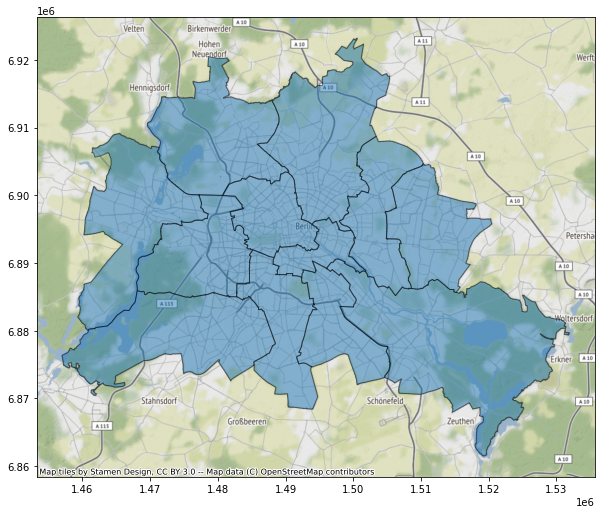

In [7]:
distr_web = distr_gdf.to_crs(epsg=3857) #converts from UTM to Web Mercator
ax = distr_web.plot(figsize=(10,10), alpha = 0.5, edgecolor='k') #set plot as axis variable (layer)
ctx.add_basemap(ax)

**The 96 Neighborhoods of Berlin**

In [8]:
urlhood = 'https://tsb-opendata.s3.eu-central-1.amazonaws.com/ortsteile/lor_ortsteile.geojson'
hood_json = requests.get(urlhood).json()

In [9]:
area = []
lats = []
lons = []
name = []

for feature in hood_json['features']:
        name.append(feature['properties']['spatial_alias'])
        polygon = shape(feature['geometry'])
        p=polygon.representative_point()
        lons.append(p.x)
        lats.append(p.y)
        
        geom_aea = ops.transform(
            pyproj.Proj(
            proj='aea',
            lat_1=polygon.bounds[1],
            lat_2=polygon.bounds[3]),
        polygon)
        a = geom_aea.area/1000**2
        area.append(a)             

neighborhoods = pd.DataFrame(data={'Neighborhood':name, 'Latitude':lats, 'Longitude':lons, 'Area':area})
neighborhoods.sort_values(['Neighborhood'], ascending=True, axis=0, inplace=True)
neighborhoods.reset_index(drop=True, inplace=True)
neighborhoods

,Neighborhood,Latitude,Longitude,Area
0,Adlershof,52.437811,13.543297,6.128075
1,Alt-Hohenschönhausen,52.548654,13.504253,9.352685
2,Alt-Treptow,52.489554,13.449517,2.313942
3,Altglienicke,52.410702,13.543510,7.876913
4,Baumschulenweg,52.457860,13.467907,4.824119
...,...,...,...,...
91,Wilhelmsruh,52.586678,13.364060,1.360359
92,Wilhelmstadt,52.514834,13.192288,10.421337
93,Wilmersdorf,52.483949,13.321453,7.160953
94,Wittenau,52.592957,13.323492,5.896168


<AxesSubplot:>

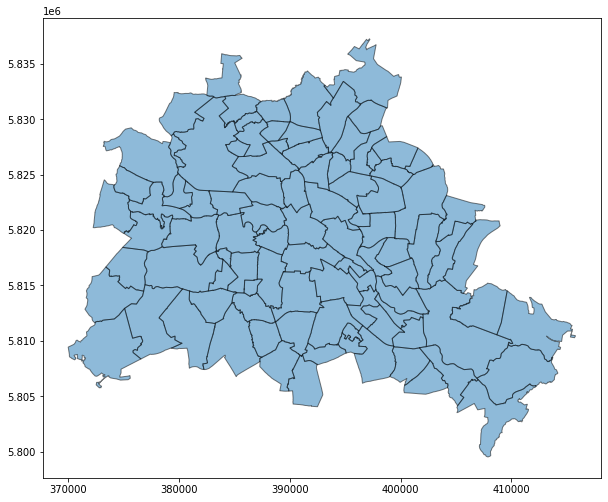

In [10]:
hood_gdf = gpd.read_file(urlhood)
hood_gdf = hood_gdf[['spatial_alias','geometry']]
hood_utm = hood_gdf.to_crs(epsg=32633) #converts to UTM Zone 33 coordinates using ESPG code
hood_utm.plot(figsize=(10,10), alpha=0.5, edgecolor='k')

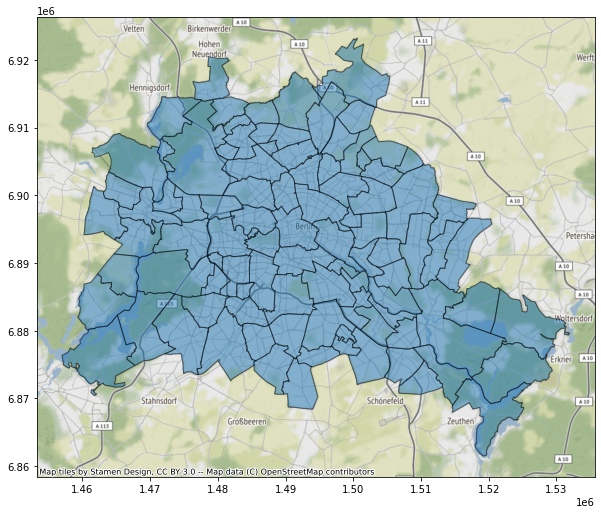

In [11]:
hood_web = hood_gdf.to_crs(epsg=3857) #converts from UTM to Web Mercator
ax = hood_web.plot(figsize=(10,10), alpha = 0.5, edgecolor='k') # set plot as axis variable
ctx.add_basemap(ax)

#### 3.1.2: Demographic Data ####

To give us additional insights into the business environments of each neighborhood or district, the registered residents in Berlin Districts is used to find the demographics in the districts and neighborhoods along the characteristic of age.

**Extracting Resident Data**

In [12]:
# extracting the dataset
url = 'https://www.statistik-berlin-brandenburg.de/opendata/EWR_Ortsteile_2019-12-31.csv'
dem_df_raw = pd.read_csv(url, encoding='latin-1', sep=';', delimiter=';')
dem_df_raw.head()

,Bezirk,Bez-Name,Ortsteil,Ortst-Name,Geschl,Staatsangeh,Altersgr,Häufigkeit
0,1,Mitte,101,Mitte,1,A,00_05,564
1,1,Mitte,101,Mitte,1,A,05_10,435
2,1,Mitte,101,Mitte,1,A,10_15,316
3,1,Mitte,101,Mitte,1,A,15_20,384
4,1,Mitte,101,Mitte,1,A,20_25,1329


In [13]:
# translating columns to English and filtering for columns to be used in this analysis
dem_df_raw.rename(columns = {'Bez-Name': 'District', 'Ortst-Name':'Neighborhood', 'Altersgr': 'AgeGroup', 'Häufigkeit' : 'Population'}, inplace=True)
dem_df_raw = dem_df_raw[['District','Neighborhood','AgeGroup','Population']]
dem_df_raw

,District,Neighborhood,AgeGroup,Population
0,Mitte,Mitte,00_05,564
1,Mitte,Mitte,05_10,435
2,Mitte,Mitte,10_15,316
3,Mitte,Mitte,15_20,384
4,Mitte,Mitte,20_25,1329
...,...,...,...,...
7174,Reinickendorf,Borsigwalde,75_80,202
7175,Reinickendorf,Borsigwalde,80_85,126
7176,Reinickendorf,Borsigwalde,85_90,63
7177,Reinickendorf,Borsigwalde,90_95,25


**Age Demographics of the 12 Districts of Berlin**

In [14]:
# group and sum age groups according to each district
dem_df_distr = dem_df_raw[['District','Population','AgeGroup']].groupby(['District', 'AgeGroup']).sum().reset_index()
dem_df_distr.head(10)

,District,AgeGroup,Population
0,Charlottenburg-Wilmersdorf,00_05,13884
1,Charlottenburg-Wilmersdorf,05_10,12350
2,Charlottenburg-Wilmersdorf,10_15,11836
3,Charlottenburg-Wilmersdorf,15_20,12137
4,Charlottenburg-Wilmersdorf,20_25,19321
5,Charlottenburg-Wilmersdorf,25_30,25644
6,Charlottenburg-Wilmersdorf,30_35,27016
7,Charlottenburg-Wilmersdorf,35_40,24120
8,Charlottenburg-Wilmersdorf,40_45,21463
9,Charlottenburg-Wilmersdorf,45_50,21563


In [15]:
# use a pivot table to set age groups as columns
dem_df_distr = pd.pivot_table(dem_df_distr[['District','Population','AgeGroup']], values='Population', index=['District'],columns=['AgeGroup'],aggfunc=np.sum)
dem_df_distr.head()

AgeGroup,00_05,05_10,10_15,15_20,20_25,25_30,30_35,35_40,40_45,45_50,50_55,55_60,60_65,65_70,70_75,75_80,80_85,85_90,90_95,95 und älter
District,,,,,,,,,,,,,,,,,,,,
Charlottenburg-Wilmersdorf,13884,12350,11836,12137,19321,25644,27016,24120,21463,21563,26021,26147,21550,20964,18310,18947,12797,5499,2727,1296
Friedrichshain-Kreuzberg,15728,12397,10703,9985,16278,30733,38990,33545,25507,19524,18975,16710,11927,8896,6147,6354,4487,2274,963,263
Lichtenberg,16586,14181,11952,10636,15710,22290,30366,25448,19087,15596,17783,20352,16847,14746,10673,13965,10486,5111,1977,409
Marzahn-Hellersdorf,14095,14019,12678,10957,11746,14776,22046,20511,16304,13578,18438,23721,21181,19018,11205,11739,8263,3826,1506,360
Mitte,19759,16471,14988,14753,28208,44257,46153,35316,27518,23942,24971,23003,17181,13907,10637,10921,8143,3797,1437,386


In [16]:
# aggregate age goups into generational bins more appropriate for this analysis
dem_df_distr['0-15'] = dem_df_distr[dem_df_distr.columns[0:3]].sum(axis = 1)
dem_df_distr['15-30'] = dem_df_distr[dem_df_distr.columns[3:6]].sum(axis = 1)
dem_df_distr['30-50'] = dem_df_distr[dem_df_distr.columns[6:10]].sum(axis = 1)
dem_df_distr['50-65'] = dem_df_distr[dem_df_distr.columns[10:13]].sum(axis = 1)
dem_df_distr['>65'] = dem_df_distr[dem_df_distr.columns[13:20]].sum(axis = 1)
dem_df_distr['Total'] = dem_df_distr[dem_df_distr.columns[1:20]].sum(axis = 1)
dem_df_distr=dem_df_distr[['0-15','15-30','30-50','50-65','>65','Total']]
dem_df_distr

AgeGroup,0-15,15-30,30-50,50-65,>65,Total
District,,,,,,
Charlottenburg-Wilmersdorf,38070,57102,94162,73718,80540,329708
Friedrichshain-Kreuzberg,38828,56996,117566,47612,29384,274658
Lichtenberg,42719,48636,90497,54982,57367,277615
Marzahn-Hellersdorf,40792,37479,72439,63340,55917,255872
Mitte,51218,87218,132929,65155,49228,365989
Neukölln,45669,59921,104802,61573,57952,313026
Pankow,62937,61169,145647,78479,61103,386572
Reinickendorf,37898,44038,64858,56975,62639,253286
Spandau,36523,41635,62364,51167,53508,232445


**Age Demographics of the 96 Neighborhoods in Berlin** (same procedure as with districts)

In [17]:
dem_df_hood = dem_df_raw[['Neighborhood','Population','AgeGroup']].groupby(['Neighborhood', 'AgeGroup']).sum().reset_index()
dem_df_hood = pd.pivot_table(dem_df_hood[['Neighborhood','Population','AgeGroup']], values='Population', index=['Neighborhood'],columns=['AgeGroup'],aggfunc=np.sum)
dem_df_hood['0-15'] = dem_df_hood[dem_df_hood.columns[0:3]].sum(axis = 1)
dem_df_hood['15-30'] = dem_df_hood[dem_df_hood.columns[3:6]].sum(axis = 1)
dem_df_hood['30-50'] = dem_df_hood[dem_df_hood.columns[6:10]].sum(axis = 1)
dem_df_hood['50-65'] = dem_df_hood[dem_df_hood.columns[10:13]].sum(axis = 1)
dem_df_hood['>65'] = dem_df_hood[dem_df_hood.columns[13:20]].sum(axis = 1)
dem_df_hood['Total'] = dem_df_hood[dem_df_hood.columns[1:20]].sum(axis = 1)
dem_df_hood = dem_df_hood[['0-15','15-30','30-50','50-65','>65','Total']]
dem_df_hood

AgeGroup,0-15,15-30,30-50,50-65,>65,Total
Neighborhood,,,,,,
Adlershof,2642.0,3930.0,6268.0,3597.0,3497.0,18778.0
Alt-Hohenschönhausen,7640.0,7219.0,14199.0,9589.0,10332.0,46128.0
Alt-Treptow,2014.0,1920.0,5450.0,2174.0,1320.0,12067.0
Altglienicke,5051.0,4299.0,8072.0,7010.0,4925.0,27653.0
Baumschulenweg,2170.0,2936.0,5797.0,3490.0,4449.0,17950.0
...,...,...,...,...,...,...
Wilhelmsruh,1102.0,1100.0,2284.0,1726.0,1795.0,7607.0
Wilhelmstadt,5343.0,6702.0,10251.0,8719.0,9521.0,38720.0
Wilmersdorf,11184.0,16186.0,27784.0,22574.0,24891.0,98597.0


#### 3.1.3 Foursquare API Venue Data for Districts and Neighborhoods ####

**Conversions between Coordinate Reference Systems (CRSs)** The peculiarities of each CRSs makes different CRSs useful in different situations.  While latitude/longitude is a geographic CRS, meaning it is referencing points on a globe.  In practice, we deal with geospatial data more often in flat maps, meaning we need a Cartesian CRS to reference points on a flat plane.  UTM is the most widely used Cartesian CRS, making it the more appropriate CRS for our purposes.  Luckily, both PyProj and GeoPandas (which is built on PyProj) makes creating conversion objects from the lat/long CRS to cartesian CRSs simple, only requiring a few lines of code, as shown throughout this section.

#### 3.1.3.a Setting up a Sampling Grid ####

This is a grid of evenly spaced points allows us to make calls to the Foursquare API throughout the entire city limits of Berlin, since the FourSquare API has a limit of returning only 50 venues per point. 

In [ ]:
proj2xy = pyproj.Proj(proj='utm',zone=33,ellps='WGS84', always_xy=False)
# convert from lon/lat to UTM x/y coordinates
x, y = proj2xy(berlin[1], berlin[0])
# convert from x/y to lon/lat by passing in inverse=True to the same 
lon, lat = proj2xy(x,y, inverse=True)
print('Berlin center coordinate, Lon= {}; Lat= {}'.format(berlin[1], berlin[0]))
print('Berlin center transform to UTM, X= {}; Y= {}'.format(x,y))
print('Berlin center reverse transform, Lon= {}; Lat= {}'.format(lon, lat))

**Finding the Center of Berlin** 
First, we will need to aggregate (aka "dissolve") our GeoJSON file of Berlin's districts to give us a geometric object that is the other borders of the city-state of Berlin. Geopandas, a high-level geospatial library built on pyproj, shapely, and others, makes the process of converting from long/lat to UTM xy coordinates quite simple.

<AxesSubplot:>

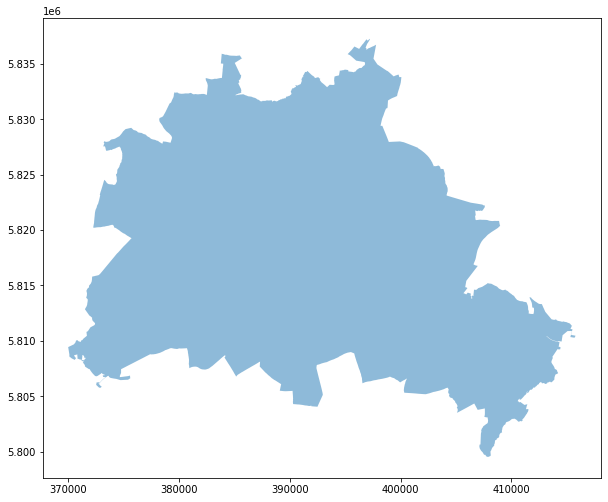

In [18]:
distr_json1 = gpd.read_file(urldistr)
distr_json1 = distr_json1[['Land_name','geometry']]
berlin_polyg = distr_json1.dissolve(by='Land_name')
berlin_polyg_utm = berlin_polyg.to_crs(epsg=32633) #converts to UTM Zone 33 coordinates using ESPG code
berlin_polyg_utm.plot(figsize=(10,10), alpha = 0.5)

Geopandas integrates well with shapely, so we can calculate central representative points as done in section 3.1.1 quite simply.

Land_name
Berlin    POINT (1491437.598 6892364.356)
dtype: geometry


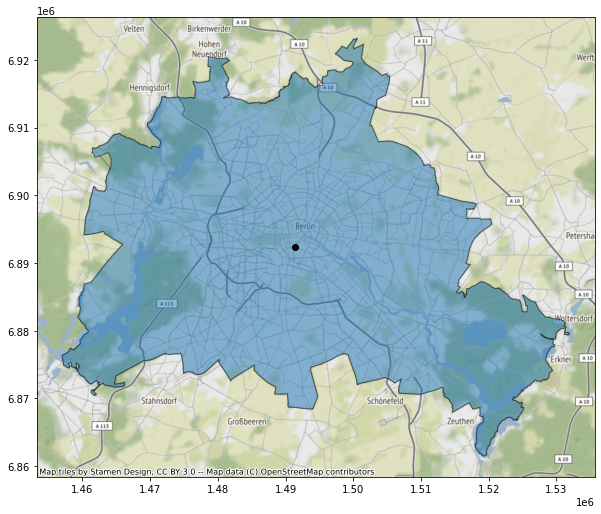

In [19]:
berlin_polyg_web = berlin_polyg.to_crs(epsg=3857)
berlin_rep = berlin_polyg_web.representative_point()
ax = berlin_rep.plot(figsize=(10,10), color='k', zorder=2)
ax1 = berlin_polyg_web.plot(ax=ax, figsize=(10,10), alpha=0.5, edgecolor='k', zorder=1)
print(berlin_rep)
ctx.add_basemap(ax1)

Geodataseries in Geopandas are a powerful tool for working with large geospatial datasets, but sometimes it can be useful to extract coordinates from the Geodataseries into a list, or a list of tuples in cases when working with multiple points.

In [20]:
berlin_rep = berlin_rep.to_crs(epsg=32633)
berlinrepxy = [[x,y] for x,y in zip(berlin_rep.x, berlin_rep.y)]
berlinrepxy = berlinrepxy[0]
berlinrepxy

[391260.0620434562, 5818662.924072426]

Pyproj's projector, the underlying library behind CRS conversions in GeoPandas, objects allow for simple conversion between cartesian (e.g. UTM) and geographic (e.g. lon/lat) CRSs, using only a few lines of code.  While ESPG codes are the simplest to use, it is worth noting that we can manually enter projections and datums if we choose to do so as well, as shown below.

In [21]:
proj2xy = pyproj.Proj(proj='utm',zone=33,ellps='WGS84', always_xy=False)
# convert from x/y to lon/lat by passing in inverse=True to the same 
lon, lat = proj2xy(berlinrepxy[0],berlinrepxy[1], inverse=True)
x_center, y_center = proj2xy(lon,lat)
print('Berlin center coordinates in UTM are, X= {}; Y= {}'.format(berlinrepxy[0], berlinrepxy[1]))
print('Berlin center transform to Longitude & Latitude, Lon= {}; Lat= {}'.format(lon,lat))
print('Berlin center reverse transform, X= {}; Y= {}'.format(x_center, y_center))

Berlin center coordinates in UTM are, X= 391260.0620434562; Y= 5818662.924072426
Berlin center transform to Longitude & Latitude, Lon= 13.397811897657961; Lat= 52.50723234441329
Berlin center reverse transform, X= 391260.06204345624; Y= 5818662.924072424


**Creating the Sampling Grid** This grid is set up for use within the UTM CRS, with 1km spacing between points, the grid is culled to ensure we remain within Berlin's city-state boundaries.  These values were obtained in the **"Determining Appropriate Sampling Grid Size"** section of notebook1, also included in this repository.

In [22]:
# set sampling grid with points at 1 km intervals
XX = np.arange(-22.99762,22.99762,1)*1000 + x_center
YY = np.arange(-18.69604,18.69604,1)*1000 + y_center

In [23]:
# convert points to lon/lat to enable calls to foursquare api
Lats =[]
Lons = []

for y in YY:
    for x in XX:
        lon, lat =proj2xy(x,y, inverse=True)
        Lats.append(lat)
        Lons.append(lon)

In [24]:
#create sampling grid in form of dataframe
df_points = pd.DataFrame(columns = ['Latitude','Longitude', 'District'])
for lon, lat in zip(Lons ,Lats):
    point = Point(lon, lat)
    for feature in distr_json['features']:
        polygon = shape(feature['geometry'])
        #print(feature['properties']['Gemeinde_name'])
        if polygon.contains(point):
            #print(feature['properties']['Gemeinde_name'])
            df_points = df_points.append({'Latitude': lat, 'Longitude': lon, 'District':feature['properties']['Gemeinde_name'] 
                                         }, ignore_index=True)
df_points=df_points.sort_values(by = 'District').reset_index()
df_points=df_points[['Latitude','Longitude', 'District']]
df_points.head()

,Latitude,Longitude,District
0,52.481137,13.266257,Charlottenburg-Wilmersdorf
1,52.498892,13.250826,Charlottenburg-Wilmersdorf
2,52.498674,13.236102,Charlottenburg-Wilmersdorf
3,52.498453,13.221378,Charlottenburg-Wilmersdorf
4,52.498231,13.206654,Charlottenburg-Wilmersdorf


Read in Foursquare API credentials

In [25]:
# FourSquare credentials read from file on local device to protect private information
KEY = pd.read_csv('~/Projects/IBMCertDS/foursquare_cred.csv')
# define FourSquare credentials and version
CLIENT_ID = KEY.iloc[0,0] 
CLIENT_SECRET = KEY.iloc[0,1] 
VERSION = '20180605' 
LIMIT = 200 

Define function that will compile relevant venue data into a dataframe

In [ ]:
# define function that will compile relevant venue data into a dataframe
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

This function is first applied function to Berlin districts with a radius of 710m is used to ensure entire area is covered, after which duplicates are removed to ensure the returned dataset will be useful for this analysis.  Due to the long execution time, the returned dataset from the initial extraction on 22/12/2020 was filtered for duplicates with a reset index and saved to the local device.  Code for both the initial extraction and loading the csv from the local device are shown below.

**Call to Foursquare API**

In [ ]:
# berlin_venues = getNearbyVenues(names=df_points['District'],
#                                    latitudes=df_points['Latitude'],
#                                    longitudes=df_points['Longitude'],
#                                    radius=710)

**Drop Duplicates and Reset Index in Extracted Dataset**

In [36]:
# berlin_venues = berlin_venues.drop_duplicates(subset=['Venue','Venue Latitude','Venue Longitude'], keep='first')
# berlin_venues.reset_index(drop=True, inplace=True)

**Saving extraction from 22/12/2020 at 16:55 to local device**

In [44]:
# saved extraction from 22/12/2020 at 16:55 to local device
# berlin_venues.to_csv(path_or_buf='~/Projects/IBMCertDS/Coursera_Capstone/data/berlin_venues.csv')

**Load saved extraction from local device**

In [40]:
berlin_venues = pd.read_csv(filepath_or_buffer='~/Projects/IBMCertDS/Coursera_Capstone/data/berlin_venues.csv', sep=',',index_col=0)

In [43]:
print(berlin_venues.shape)
berlin_venues.head()

(9702, 7)


,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Charlottenburg-Wilmersdorf,52.481137,13.266257,Hagenplatz,52.483307,13.266410,Plaza
1,Charlottenburg-Wilmersdorf,52.481137,13.266257,Schlosshotel im Grunewald,52.480191,13.274295,Hotel
2,Charlottenburg-Wilmersdorf,52.481137,13.266257,Reinhards Landhaus,52.482859,13.264800,German Restaurant
3,Charlottenburg-Wilmersdorf,52.481137,13.266257,Wiener am Hagenplatz,52.483740,13.267298,Café
4,Charlottenburg-Wilmersdorf,52.481137,13.266257,Bosco Verde,52.482562,13.266436,Italian Restaurant


In [ ]:
# apply function to Berlin neighborhoods with a radius of 500m
neighborhood_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude'],
                                   radius=500)

In [ ]:
print(neighborhood_venues.shape)
neighborhood_venues.head()

In [ ]:
# saved extraction from 17/12/2020 at 15:28 to local device
# neighborhood_venues.to_csv(path_or_buf='~/Projects/IBMCertDS/Coursera_Capstone/data/neighborhood_venues.csv')